## This notebook will explore the relationship between a country's various factors and the life expectancy of that country.  Regression will then be used to provide that relationship.

## Relevant functions

In [1]:
def convert_cat(df, cat_cols,output_col=None):
    """
    This function converts all categorical columns into numerical boolean columns.
    
    There are 3 parameters: df, cat_cols, and output_var. 
    
    1. df is the dataframe which needs to have categorical variables converted to numerical variables
    2. cat_cols needs to be a list that contains the names of all categorical columns that need to be converted.
    3. output_var is the name of the output or response variable.  It is set to 'Output' as default."""
    
    df.reset_index(inplace = True, drop = True)
    df_out = df.copy()
    
    for col in cat_cols:
        dummy_col = pd.get_dummies(df_out[col],drop_first = True)
        df_out.drop(col,axis=1, inplace = True)
        df_out = df_out.join(dummy_col)
    
    if output_col != None:
        loc_df_out = list(df_out.columns).index(output_col)
        df_out = df_out[list(df_out.columns[:loc_df_out]) + list(df_out.columns[loc_df_out + 1:]) + list(df_out.columns[loc_df_out:loc_df_out + 1])]
    return df_out

In [2]:
def normalize(df,cat_class = None):
    """
    This function takes in a dataframe as a parameter and returns the same dataframe with all the features normalized between 0 and 1 using rescaling (min-max normalization)
    """
    l_min = []
    l_max = []
    if cat_class == None:
        for col in df.columns:
            l_min.append(df.describe()[col]['min'])
            l_max.append(df.describe()[col]['max'])
        
        t_min = list(zip(df.columns, l_min))
        t_max = list(zip(df.columns, l_max))
 

    else:
        for col in df.drop(cat_class,axis = 1).columns:
            l_min.append(df.describe()[col]['min'])
            l_max.append(df.describe()[col]['max'])

        t_min = list(zip(df.drop(cat_class,axis = 1).columns, l_min))
        t_max = list(zip(df.drop(cat_class,axis = 1).columns, l_max))
    
   
    d_min = {}
    for col,val in t_min:
        d_min[col]=val
    
    d_max = {}
    for col,val in t_max:
        d_max[col]=val
    
    df_copy = df.copy()
    for key in d_min.keys():
        df_copy[key] = df_copy[key].apply(lambda x: (x - d_min[key])/ (d_max[key] - d_min[key]))
    
    return df_copy

In [3]:
def split_df(df,test_size = 0.3,df_to_return = 'df_train'):
    """
    This function takes in a Pandas DataFrame and returns a 
    dataframe that is a subset of that Pandas DataFrame.
    
    There are 3 parameters: df, test_size, and df_to_return
    
    df needs to be a Pandas DataFrame and is the superset dataframe to be divided.
    test_size is the proportion of the dataframe you want to be the testing dataset.
    test_size is set to 0.3 by default.
    df_to_return needs to specified as either 'df_train' or df_test' 
    to return the correct subset dataframe. df_to_return is set to 'df_train' by default
    """
    split_num = int(df.count()[0] * (1-test_size) //1)
    df_train = df.iloc[:split_num,:]
    df_test = df.iloc[split_num:,:]
    if df_to_return in ['df_train','train']:
        return df_train
    elif df_to_return in ['df_test','test']:
        return df_test

In [4]:
def check_accuracy(df = None,pred_df = None, test_df = None, algo = 'lin',target_class = None):
    """
    This function takes in a pandas DataFrame and returns the accuracy of the model
    
    There are 2 parameters: df and algo
    
    1. df needs to be a Pandas DataFrame and algo is the algorithm used.
    2. algo is set to 'lin' by default but can also be specified as 'log'"""
    
    if algo == 'lin':
        df_out = df.copy()
        df_out['error'] = df.iloc[:,-2] - df.iloc[:,-1]
        RMSE = (sum(df_out['error']**2)/df_out.count()[0]+1) ** 0.5
        acc = (np.mean(df_out.iloc[:,-3]) - RMSE) / np.mean(df_out.iloc[:,-3])
        return {'acc':acc,'RMSE':RMSE}
    
    elif algo == 'log':
        return sum(df['Correct?']/df.count()[0])
    
    elif algo == 'knn':
        pred = pred_df[target_class]
        test = test_df[target_class]
        return sum(pred == test) / len(pred)

# Linear Regression and Logistic Regression

In [60]:
def stoch_grad_desc(dataset,output_col,cols_to_ignore = None,alpha = 0.3,epoch = 10,algo = 'lin',initial_coeffs = 1):
    """
    This function returns a list of the coefficients for the specified algorithm.  
    Currently, this function only performs Linear and Logistic Regression.
    
    The 4 parameters are: dataset, alpha, epoch, and algo
    
    1. dataset needs to be a pandas DataFrame
    2. alpha is the alpha value used in stochiastic gradient descent.  It is set at 0.3 by default.
    3. epoch is the number of iterations through each row in the dataset algorithm will perform.  epoch is set to 10 by default.
    4. algo is the specific algorithm to be used.  algo is 'lin' by default for Linear Regression but can also be specified as 'log' for Logistic Regression
    """

    loc_output_col = list(dataset.columns).index(output_col)
    dataset = dataset[list(dataset.columns[:loc_output_col]) + list(dataset.columns[loc_output_col+1:]) + list(dataset.columns[loc_output_col:loc_output_col + 1])]
    
    from math import exp
    count_rows = dataset.count()[1]
    
    if cols_to_ignore != None:
        dataset_1 = pd.DataFrame(pd.Series(np.ones(dataset.count()[0])),columns = ['X0']).join(dataset.drop(cols_to_ignore,axis = 1))
    else:
        dataset_1 = pd.DataFrame(pd.Series(np.ones(dataset.count()[0])),columns = ['X0']).join(dataset)
        
    coeffs = list(np.ones(len(dataset_1.columns[0:-1])))
    coeffs = [i * initial_coeffs for i in coeffs]
    
    df_columns = list(dataset_1.columns)
    df_input_cols = df_columns
    df_input_cols.remove(output_col)
    
    for ep in range(epoch):
        for row in range(count_rows):
            y = dataset_1.loc[row,output_col]
            output_terms = []
            #return y
            for col in df_input_cols:
                output_terms.append((coeffs[dataset_1.columns.get_loc(col)],dataset_1.loc[row,col]))
            
            output_list = [(x*y) for (x,y) in output_terms]
            
            output = sum(output_list)
            
            if algo == 'lin':
                pred = output
                for i in range(len(coeffs)):
                    coeffs[int(i)] += alpha * (dataset_1.loc[row,output_col] - pred) * dataset_1.iloc[row,int(i)]
                
            elif algo == 'log':
                pred = 1 / (1 + exp(-output))
                
                for i in range(len(coeffs)):
                    coeffs[i] = coeffs[i] + alpha * (y - pred) * pred * (1 - pred) * dataset_1.iloc[row,i]
                    
    
    
    return coeffs
        

In [6]:
def make_predictions(dataset, coeff_list, output_col,cols_to_ignore = None,algo = 'lin'):
    """
    This function takes in a pandas DataFrame and a list that contains 
    coefficients for the specified algorith used in the stoch_grad_desc function
    and returns the same dataset (with the addition of the first column being 1s to
    represent X0 in the regression formula) plus a new column at the end, 'Prediction'.
    
    There are 3 parameters: dataset, coeff_list, and algo
    
    1. dataset is the dataframe to used to make predictions dataset needs to be a Pandas DataFrame
    2. coeff_list should be the list that was the result of running the stoch_grad_desc function
    3. algo is the specific algorithm to be used.  algo is set to 'lin' by default but can be set to 'log'"""
    dataframe = dataset.copy()
    if output_col not in dataframe.columns:
        dataframe[output_col] = np.zeros(len(list(dataframe.index)))
        #return dataframe
    
    elif output_col in dataframe.columns:
        #return 'no'
        loc_output_col = list(dataset.columns).index(output_col)
        dataframe = dataframe[list(dataframe.columns[:loc_output_col]) + list(dataframe.columns[loc_output_col+1:]) + list(dataframe.columns[loc_output_col:loc_output_col + 1])]
        
    dataset_index = dataframe.index
    
    if type(cols_to_ignore) == list and cols_to_ignore != None:
        df_ignored_cols = dataset.loc[:,cols_to_ignore]
    elif type(cols_to_ignore) != list and cols_to_ignore != None:
        df_ignored_cols = dataset.loc[:,[cols_to_ignore]]
    if cols_to_ignore != None:
        df_ignored_cols.reset_index(inplace = True)
    
    from math import exp
    
    dataframe.reset_index(inplace = True, drop = True)
    
    if cols_to_ignore != None and output_col in dataset.columns:
        dataset_out = pd.DataFrame(pd.Series(np.ones(dataframe.count()[0]))).join(dataframe.drop(cols_to_ignore,axis = 1))
        
    else:
        dataset_out = pd.DataFrame(pd.Series(np.ones(dataframe.count()[0]))).join(dataframe)
    
    if output_col not in dataset.columns:
        dataset_out.drop(cols_to_ignore,axis = 1,inplace = True)

    
    dataset_out.rename(mapper = {0:'X0'},axis = 1, inplace = True)
    #return dataset_out
    coeffs = coeff_list
    pred = []
    
    for row in range(dataset_out.count()[0]):
        output_terms = []
        for col in dataset_out.columns[0:-1]:
            if output_col not in dataframe.columns:
                output_terms.append((coeffs[dataset_out.columns.get_loc(col)],dataset_out.loc[row,col]))
            elif output_col in dataframe.columns:
                output_terms.append((coeffs[dataset_out.columns.get_loc(col)],dataset_out.loc[row,col]))
        output_list = [x*y for (x,y) in output_terms]
        
        output = sum(output_list)
        if algo == 'lin':
            pred.append(output)
        
        elif algo == 'log':
            pred.append(1/(1 + exp(-output)))
    dataset_out = dataset_out.join(pd.DataFrame(pred))
    dataset_out.rename(mapper = {0: 'Prediction'},axis = 1, inplace = True)
    
    if algo == 'log':
        dataset_out['Crisp'] = dataset_out['Prediction'].apply(lambda predi: 1 if predi >= 0.5 else 0)
        dataset_out['Correct?'] = dataset_out.iloc[:,-3] == dataset_out['Crisp']
    
    if cols_to_ignore != None:
        dataset_out = pd.concat([df_ignored_cols,dataset_out],axis = 1)
    dataset_out.drop('X0',axis = 1,inplace = True)
    
    dataset_out.set_index(dataset_index,inplace = True)
    return dataset_out

### Importing relevant packages

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

In [9]:
plt.rcParams['figure.figsize'] = (15,9)

In [10]:
sns.set_style('darkgrid')

In [11]:
plt.rcParams['axes.labelsize'] = 20

In [12]:
pd.set_option('display.max_rows',None)

In [13]:
pd.set_option('display.max_columns',None)

#### I am reading the Life Expectancy Data csv file into an object named life

In [14]:
life = pd.read_csv(r'Life Expectancy Data.csv')

In [15]:
life.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


#### Preliminary EDA

In [16]:
life.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

In [16]:
life.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


In [17]:
life.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


I am placing 'Life expectancy' column at the end since it is the output variable

In [18]:
life = life[list(life.columns[0:3]) + list(life.columns[4:]) + list(life.columns[3:4])]

In [19]:
life.head()

,Country,Year,Status,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Life expectancy
0,Afghanistan,2015,Developing,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,65.0
1,Afghanistan,2014,Developing,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,59.9
2,Afghanistan,2013,Developing,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,59.9
3,Afghanistan,2012,Developing,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,59.5
4,Afghanistan,2011,Developing,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,59.2


## Null value treatment

In [20]:
life.isna().sum()

Country                              0
Year                                 0
Status                               0
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
Life expectancy                     10
dtype: int64

In [21]:
na_cols = list(life.isna().sum()[life.isna().sum() != 0].index)

In [22]:
na_cols

['Adult Mortality',
 'Alcohol',
 'Hepatitis B',
 ' BMI ',
 'Polio',
 'Total expenditure',
 'Diphtheria ',
 'GDP',
 'Population',
 ' thinness  1-19 years',
 ' thinness 5-9 years',
 'Income composition of resources',
 'Schooling',
 'Life expectancy ']

In [23]:
life[life.isna().any(axis =1)].head()

,Country,Year,Status,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Life expectancy
32,Algeria,2015,Developing,19.0,21,NaN,0.000000,95.0,63,59.5,24,95.0,NaN,95.0,0.1,4132.762920,39871528.0,6.0,5.8,0.743,14.4,75.6
44,Algeria,2003,Developing,146.0,20,0.34,25.018523,NaN,15374,47.0,23,87.0,3.60,87.0,0.1,294.335560,3243514.0,6.3,6.1,0.663,11.5,71.7
45,Algeria,2002,Developing,145.0,20,0.36,148.511984,NaN,5862,46.1,23,86.0,3.73,86.0,0.1,1774.336730,3199546.0,6.3,6.2,0.653,11.1,71.6
46,Algeria,2001,Developing,145.0,20,0.23,147.986071,NaN,2686,45.3,24,89.0,3.84,89.0,0.1,1732.857979,31592153.0,6.4,6.3,0.644,10.9,71.4
47,Algeria,2000,Developing,145.0,21,0.25,154.455944,NaN,0,44.4,25,86.0,3.49,86.0,0.1,1757.177970,3118366.0,6.5,6.4,0.636,10.7,71.3


I am imputing the null values based on the mean value for the same country

In [24]:
for col in na_cols:
    life[col] = life[['Country',col]].apply(lambda cols: life[life['Country'] == cols[0]].mean()[col] if math.isnan(cols[1]) else cols[1] ,axis = 1)

In [25]:
life.head()

,Country,Year,Status,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Life expectancy
0,Afghanistan,2015,Developing,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,65.0
1,Afghanistan,2014,Developing,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,59.9
2,Afghanistan,2013,Developing,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,59.9
3,Afghanistan,2012,Developing,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,59.5
4,Afghanistan,2011,Developing,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,59.2


In [26]:
life.isna().sum()

Country                              0
Year                                 0
Status                               0
Adult Mortality                     10
infant deaths                        0
Alcohol                             17
percentage expenditure               0
Hepatitis B                        144
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                                0
Total expenditure                   32
Diphtheria                           0
 HIV/AIDS                            0
GDP                                405
Population                         648
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
Life expectancy                     10
dtype: int64

The remaining null values exist because the country throughout all the years for these columns did not have a single value to take the mean of.

In [27]:
life[life.isna().any(axis = 1)]

,Country,Year,Status,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Life expectancy
64,Antigua and Barbuda,2015,Developing,13.0,0,7.949333,0.000000,99.000000,0,47.7,0,86.0,4.791333,99.0,0.2,13566.954100,NaN,3.3,3.3,0.784,13.9,76.4
65,Antigua and Barbuda,2014,Developing,131.0,0,8.560000,2422.999774,99.000000,0,47.0,0,96.0,5.540000,99.0,0.2,12888.296670,NaN,3.3,3.3,0.782,13.9,76.2
66,Antigua and Barbuda,2013,Developing,133.0,0,8.580000,1991.430372,99.000000,0,46.4,0,98.0,5.330000,99.0,0.2,12224.864160,NaN,3.3,3.3,0.781,13.9,76.1
67,Antigua and Barbuda,2012,Developing,134.0,0,8.180000,2156.229842,98.000000,0,45.7,0,97.0,5.390000,98.0,0.2,12565.441970,NaN,3.3,3.3,0.778,13.8,75.9
68,Antigua and Barbuda,2011,Developing,136.0,0,7.840000,1810.875316,99.000000,0,45.1,0,99.0,5.650000,99.0,0.1,11929.349910,NaN,3.3,3.3,0.782,14.1,75.7
69,Antigua and Barbuda,2010,Developing,138.0,0,7.840000,1983.956937,98.000000,0,44.4,0,99.0,5.630000,98.0,0.1,12126.876140,NaN,3.3,3.3,0.783,14.1,75.6
70,Antigua and Barbuda,2009,Developing,14.0,0,7.820000,149.358735,98.000000,0,43.8,0,98.0,4.860000,99.0,0.1,1312.466920,NaN,3.4,3.3,0.788,14.2,75.4
71,Antigua and Barbuda,2008,Developing,142.0,0,8.270000,180.776270,98.000000,0,43.2,0,99.0,4.690000,99.0,0.1,1473.319230,NaN,3.4,3.3,0.786,14.4,75.2
72,Antigua and Barbuda,2007,Developing,144.0,0,8.640000,257.966531,97.000000,0,42.6,0,98.0,4.270000,99.0,0.1,14252.294520,NaN,3.4,3.3,0.781,14.5,75.0
73,Antigua and Barbuda,2006,Developing,145.0,0,8.930000,216.314694,99.000000,0,42.0,0,99.0,4.340000,99.0,0.1,12724.393770,NaN,3.4,3.4,0.773,14.7,74.8


In [28]:
life_2015 = life[life["Year"] == 2015].reset_index(drop = True)

In [29]:
life_2015.head()

,Country,Year,Status,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Life expectancy
0,Afghanistan,2015,Developing,263.0,62,0.010000,71.279624,65.0,1154,19.1,83,6.0,8.160000,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,65.0
1,Albania,2015,Developing,74.0,0,4.600000,364.975229,99.0,0,58.0,0,99.0,6.000000,99.0,0.1,3954.227830,28873.0,1.2,1.3,0.762,14.2,77.8
2,Algeria,2015,Developing,19.0,21,0.406667,0.000000,95.0,63,59.5,24,95.0,4.604000,95.0,0.1,4132.762920,39871528.0,6.0,5.8,0.743,14.4,75.6
3,Angola,2015,Developing,335.0,66,5.740667,0.000000,64.0,118,23.3,98,7.0,3.919333,64.0,1.9,3695.793748,2785935.0,8.3,8.2,0.531,11.4,52.4
4,Antigua and Barbuda,2015,Developing,13.0,0,7.949333,0.000000,99.0,0,47.7,0,86.0,4.791333,99.0,0.2,13566.954100,NaN,3.3,3.3,0.784,13.9,76.4


In [30]:
life_2015.drop('Year',axis = 1,inplace = True)

In [30]:
life_2015.isna().sum()

Country                             0
Year                                0
Status                              0
Adult Mortality                     0
infant deaths                       0
Alcohol                             1
percentage expenditure              0
Hepatitis B                         9
Measles                             0
 BMI                                2
under-five deaths                   0
Polio                               0
Total expenditure                   2
Diphtheria                          0
 HIV/AIDS                           0
GDP                                25
Population                         40
 thinness  1-19 years               2
 thinness 5-9 years                 2
Income composition of resources    10
Schooling                          10
Life expectancy                     0
dtype: int64

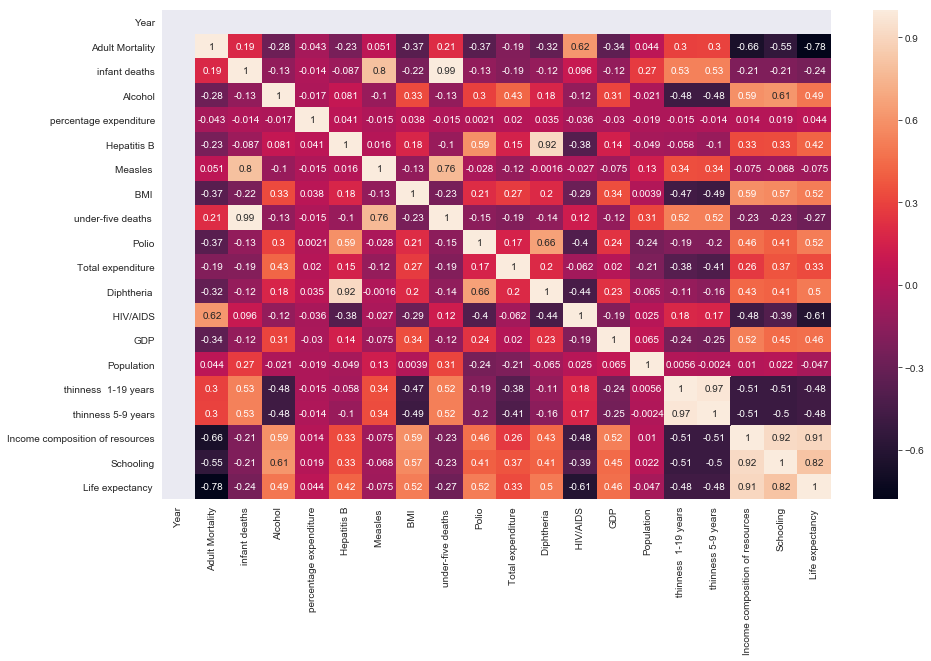

In [31]:
sns.heatmap(life_2015.corr(),annot = True)

# Linear Regression Model

In [32]:
life_2015.columns

Index(['Country', 'Year', 'Status', 'Adult Mortality', 'infant deaths',
       'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ',
       'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ',
       ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years',
       ' thinness 5-9 years', 'Income composition of resources', 'Schooling',
       'Life expectancy '],
      dtype='object')

In [99]:
life_2015.drop('Year',axis = 1,inplace = True)

In [100]:
life_converted = convert_cat(life_2015,cat_cols = ['Status'],output_col = 'Life expectancy ')

In [101]:
life_converted.head()

,Country,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Developing,Life expectancy
0,Afghanistan,263.0,62,0.010000,71.279624,65.0,1154,19.1,83,6.0,8.160000,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,1,65.0
1,Albania,74.0,0,4.600000,364.975229,99.0,0,58.0,0,99.0,6.000000,99.0,0.1,3954.227830,28873.0,1.2,1.3,0.762,14.2,1,77.8
2,Algeria,19.0,21,0.406667,0.000000,95.0,63,59.5,24,95.0,4.604000,95.0,0.1,4132.762920,39871528.0,6.0,5.8,0.743,14.4,1,75.6
3,Angola,335.0,66,5.740667,0.000000,64.0,118,23.3,98,7.0,3.919333,64.0,1.9,3695.793748,2785935.0,8.3,8.2,0.531,11.4,1,52.4
4,Antigua and Barbuda,13.0,0,7.949333,0.000000,99.0,0,47.7,0,86.0,4.791333,99.0,0.2,13566.954100,NaN,3.3,3.3,0.784,13.9,1,76.4


In [102]:
life_converted.isna().sum()

Country                             0
Adult Mortality                     0
infant deaths                       0
Alcohol                             1
percentage expenditure              0
Hepatitis B                         9
Measles                             0
 BMI                                2
under-five deaths                   0
Polio                               0
Total expenditure                   2
Diphtheria                          0
 HIV/AIDS                           0
GDP                                25
Population                         40
 thinness  1-19 years               2
 thinness 5-9 years                 2
Income composition of resources    10
Schooling                          10
Developing                          0
Life expectancy                     0
dtype: int64

In [103]:
for col in life_converted.drop('Country',axis = 1).columns:
    life_converted[col] = life_converted[col].apply(lambda x: life_converted[col].mean() if math.isnan(x) else x)

In [104]:
life_converted.head()

,Country,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Developing,Life expectancy
0,Afghanistan,263.0,62,0.010000,71.279624,65.0,1154,19.1,83,6.0,8.160000,65.0,0.1,584.259210,3.373649e+07,17.2,17.3,0.479,10.1,1,65.0
1,Albania,74.0,0,4.600000,364.975229,99.0,0,58.0,0,99.0,6.000000,99.0,0.1,3954.227830,2.887300e+04,1.2,1.3,0.762,14.2,1,77.8
2,Algeria,19.0,21,0.406667,0.000000,95.0,63,59.5,24,95.0,4.604000,95.0,0.1,4132.762920,3.987153e+07,6.0,5.8,0.743,14.4,1,75.6
3,Angola,335.0,66,5.740667,0.000000,64.0,118,23.3,98,7.0,3.919333,64.0,1.9,3695.793748,2.785935e+06,8.3,8.2,0.531,11.4,1,52.4
4,Antigua and Barbuda,13.0,0,7.949333,0.000000,99.0,0,47.7,0,86.0,4.791333,99.0,0.2,13566.954100,1.103429e+07,3.3,3.3,0.784,13.9,1,76.4


In [105]:
life_converted[life_converted.isna().any(axis = 1)]

,Country,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Developing,Life expectancy


In [116]:
life_norm = normalize(life_converted,cat_class = ['Country','Life expectancy '])

In [117]:
life_norm

,Country,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Developing,Life expectancy
0,Afghanistan,0.542443,0.068132,0.000000,0.1953,0.634409,0.012767,0.221039,0.075455,0.010638,0.458148,0.634409,0.000000,0.008303,0.130670,0.642857,0.632353,0.219634,0.335484,1.0,65.0
1,Albania,0.151139,0.000000,0.340319,1.0000,1.000000,0.000000,0.739015,0.000000,1.000000,0.306213,1.000000,0.000000,0.059122,0.000100,0.041353,0.044118,0.690516,0.600000,1.0,77.8
2,Algeria,0.037267,0.023077,0.029410,0.0000,0.956989,0.000697,0.758988,0.021818,0.957447,0.208019,0.956989,0.000000,0.061814,0.154434,0.221805,0.209559,0.658902,0.612903,1.0,75.6
3,Angola,0.691511,0.072527,0.424892,0.0000,0.623656,0.001305,0.276964,0.089091,0.021277,0.159859,0.623656,0.195652,0.055225,0.010780,0.308271,0.297794,0.306156,0.419355,1.0,52.4
4,Antigua and Barbuda,0.024845,0.000000,0.588651,0.0000,1.000000,0.000000,0.601864,0.000000,0.861702,0.221196,1.000000,0.010870,0.204082,0.042731,0.120301,0.117647,0.727121,0.580645,1.0,76.4
5,Argentina,0.238095,0.008791,0.589936,0.0000,0.946237,0.000000,0.802929,0.008182,0.936170,0.370410,0.946237,0.000000,0.202577,0.168171,0.033835,0.029412,0.797005,0.800000,1.0,76.3
6,Armenia,0.242236,0.001099,0.273788,0.0000,0.946237,0.000365,0.697736,0.000909,0.968085,0.226120,0.946237,0.000000,0.005066,0.001118,0.075188,0.077206,0.655574,0.503226,1.0,74.8
7,Australia,0.120083,0.001099,0.752212,0.0000,0.935484,0.000819,0.853529,0.000909,0.936170,0.505744,0.935484,0.000000,0.852334,0.092138,0.018797,0.018382,0.981697,1.000000,0.0,82.8
8,Austria,0.132505,0.000000,0.906480,0.0000,0.935484,0.003419,0.733688,0.000000,0.936170,0.215850,0.935484,0.000000,0.657976,0.033430,0.067669,0.073529,0.906822,0.709677,0.0,81.5
9,Azerbaijan,0.242236,0.005495,0.072809,0.0000,0.967742,0.000000,0.665779,0.005455,0.989362,0.283658,0.967742,0.000000,0.000326,0.037366,0.101504,0.102941,0.683860,0.503226,1.0,72.7


In [118]:
life_norm.isna().sum()

Country                            0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
 BMI                               0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
 HIV/AIDS                          0
GDP                                0
Population                         0
 thinness  1-19 years              0
 thinness 5-9 years                0
Income composition of resources    0
Schooling                          0
Developing                         0
Life expectancy                    0
dtype: int64

In [119]:
df = pd.DataFrame(data = [[3,4,4,0],[5,6,7,0],[3,3,4,0],[8,7,10,1],[1,3,3,0],[3,2,2,0],[7,4,6,1],[5,6,6,1],[4,3,3,1],[2,1,4,0],[8,9,11,1],[6,4,5,1],[7,3,5,1],[2,4,5,0],[3,5,3,0],[1,1,1,0],[2,2,3,0],[4,2,3,0],[4,5,3,1],[10,10,11,1],[9,9,8,1],[7,8,10,1],[7,6,9,1],[12,5,10,1],[3,10,6,1],[8,2,6,0],[10,5,9,1],[12,6,9,1],[10,12,14,1]],columns = ['height','age','weight','sick'])

In [120]:
stoch_grad_desc(df,'weight','sick',initial_coeffs=1,alpha = 0.01,epoch = 100)

[-0.7920683642643465, 0.8927311095348971, 1.0546932987388566]

In [121]:
life_train = split_df(df = life_norm)

In [122]:
life_train.head()

,Country,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Developing,Life expectancy
0,Afghanistan,0.542443,0.068132,0.000000,0.1953,0.634409,0.012767,0.221039,0.075455,0.010638,0.458148,0.634409,0.000000,0.008303,0.130670,0.642857,0.632353,0.219634,0.335484,1.0,65.0
1,Albania,0.151139,0.000000,0.340319,1.0000,1.000000,0.000000,0.739015,0.000000,1.000000,0.306213,1.000000,0.000000,0.059122,0.000100,0.041353,0.044118,0.690516,0.600000,1.0,77.8
2,Algeria,0.037267,0.023077,0.029410,0.0000,0.956989,0.000697,0.758988,0.021818,0.957447,0.208019,0.956989,0.000000,0.061814,0.154434,0.221805,0.209559,0.658902,0.612903,1.0,75.6
3,Angola,0.691511,0.072527,0.424892,0.0000,0.623656,0.001305,0.276964,0.089091,0.021277,0.159859,0.623656,0.195652,0.055225,0.010780,0.308271,0.297794,0.306156,0.419355,1.0,52.4
4,Antigua and Barbuda,0.024845,0.000000,0.588651,0.0000,1.000000,0.000000,0.601864,0.000000,0.861702,0.221196,1.000000,0.010870,0.204082,0.042731,0.120301,0.117647,0.727121,0.580645,1.0,76.4


In [123]:
life_test = split_df(df = life_norm,df_to_return='test')

In [124]:
life_test.head()

,Country,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Developing,Life expectancy
128,Portugal,0.155280,0.000000,0.904651,0.0,0.989247,0.000089,0.786951,0.000000,0.989362,0.443564,0.989247,0.0,0.028486,0.000515,0.022556,0.014706,0.821963,0.754839,0.0,81.1
129,Qatar,0.138716,0.000000,0.079433,0.0,1.000000,0.000199,0.889481,0.000000,1.000000,0.067151,1.000000,0.0,1.000000,0.042731,0.191729,0.176471,0.845258,0.548387,1.0,78.2
130,Republic of Korea,0.130435,0.001099,0.655825,0.0,0.989247,0.000077,0.388815,0.001818,0.989362,0.300023,0.989247,0.0,0.105744,0.042731,0.052632,0.033088,0.573610,0.517882,1.0,82.3
131,Republic of Moldova,0.322981,0.001099,0.706984,0.0,0.881720,0.000000,0.677763,0.000909,0.882979,0.373505,0.870968,0.0,0.105744,0.042731,0.097744,0.099265,0.573610,0.517882,1.0,72.1
132,Romania,0.273292,0.002198,0.664228,0.0,0.032258,0.000044,0.055925,0.001818,0.893617,0.255428,0.892473,0.0,0.134591,0.076745,0.090226,0.095588,0.750416,0.632258,0.0,75.0


In [197]:
coeffs = stoch_grad_desc(dataset = life_train,cols_to_ignore = 'Country',output_col = 'Life expectancy ',alpha = 0.02,epoch=200,initial_coeffs= 0)

In [198]:
coeffs

[61.290072423804325,
 -10.881152387439705,
 -1.3602915906141106,
 -2.4785631022490997,
 1.2563371136428618,
 0.02662537560120506,
 3.9355082080410613,
 -0.35851479621433446,
 -3.78508682805736,
 1.5323423859007215,
 9.288523264702611,
 1.5975935772664231,
 -7.757347894710602,
 1.1754674091372441,
 1.6448067402353772,
 -1.28033294392213,
 1.4329599066854912,
 18.403604968596298,
 -0.11478119249981598,
 -0.7016676782712715]

In [199]:
preds_life = make_predictions(dataset = life_test,coeff_list = coeffs,output_col = 'Life expectancy ',cols_to_ignore = 'Country',algo = 'lin')

In [200]:
preds_life

,index,Country,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Developing,Life expectancy,Prediction
128,128,Portugal,0.155280,0.000000,0.904651,0.0,0.989247,0.000089,0.786951,0.000000,0.989362,0.443564,0.989247,0.000000,0.028486,0.000515,0.022556,0.014706,0.821963,0.754839,0.0,81.1,79.386254
129,129,Qatar,0.138716,0.000000,0.079433,0.0,1.000000,0.000199,0.889481,0.000000,1.000000,0.067151,1.000000,0.000000,1.000000,0.042731,0.191729,0.176471,0.845258,0.548387,1.0,78.2,79.090318
130,130,Republic of Korea,0.130435,0.001099,0.655825,0.0,0.989247,0.000077,0.388815,0.001818,0.989362,0.300023,0.989247,0.000000,0.105744,0.042731,0.052632,0.033088,0.573610,0.517882,1.0,82.3,73.977389
131,131,Republic of Moldova,0.322981,0.001099,0.706984,0.0,0.881720,0.000000,0.677763,0.000909,0.882979,0.373505,0.870968,0.000000,0.105744,0.042731,0.097744,0.099265,0.573610,0.517882,1.0,72.1,72.019769
132,132,Romania,0.273292,0.002198,0.664228,0.0,0.032258,0.000044,0.055925,0.001818,0.893617,0.255428,0.892473,0.000000,0.134591,0.076745,0.090226,0.095588,0.750416,0.632258,0.0,75.0,75.852487
133,133,Russian Federation,0.457557,0.014286,0.824329,0.0,0.978495,0.009327,0.053262,0.013636,0.978723,0.321923,0.978495,0.000000,0.140178,0.005604,0.082707,0.080882,0.762063,0.651613,1.0,75.0,73.726202
134,134,Rwanda,0.467909,0.012088,0.417132,0.0,0.989247,0.000011,0.251664,0.013636,1.000000,0.330879,0.989247,0.032609,0.000568,0.045037,0.210526,0.205882,0.242928,0.380645,1.0,66.1,64.791698
135,135,Saint Lucia,0.283644,0.000000,0.852751,0.0,1.000000,0.000000,0.599201,0.000000,1.000000,0.371114,1.000000,0.000000,0.105744,0.042731,0.157895,0.154412,0.645591,0.529032,1.0,75.2,73.811436
136,136,Saint Vincent and the Grenadines,0.320911,0.000000,0.452276,0.0,0.989247,0.000000,0.687084,0.000000,0.978723,0.222931,0.989247,0.000000,0.105744,0.042731,0.127820,0.121324,0.620632,0.541935,1.0,73.2,72.470840
137,137,Samoa,0.256729,0.000000,0.199743,0.0,0.569892,0.000000,0.961385,0.000000,0.595745,0.258757,0.645161,0.000000,0.062065,0.000739,0.003759,0.000000,0.590682,0.516129,1.0,74.0,72.198188


In [201]:
check_accuracy(df = preds_life)

{'RMSE': 3.842890975161023, 'acc': 0.946384159804709}

# Linear Regression Scikit-Learn

In [160]:
from sklearn.model_selection import train_test_split

In [161]:
X = life_norm.drop(['Country','Life expectancy '],axis = 1)
y = life_norm['Life expectancy ']

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [163]:
from sklearn.linear_model import LinearRegression

In [164]:
linreg = LinearRegression()

In [165]:
linreg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [166]:
pred = linreg.predict(X_test)

In [167]:
pred

array([73.7809707 , 71.80538893, 80.95959455, 55.57849595, 81.83418086,
       55.96291183, 67.54535064, 72.16095709, 82.20370308, 75.84686121,
       75.29302488, 81.4773477 , 79.33834909, 69.59827187, 62.59117998,
       53.54158501, 72.97962458, 64.10526545, 81.56580992, 79.79145884,
       76.79224208, 82.83405319, 51.55840911, 61.09577877, 76.32764131,
       65.70198959, 81.76074504, 68.81212874, 73.48837937, 77.05478401,
       62.94945745, 73.62480494, 75.71114145, 62.63648469, 70.86608488,
       73.00774016, 76.40071774, 63.51709147, 55.32748353, 28.88012738,
       65.25521533, 54.26741057, 64.24461734, 61.10094743, 77.2108681 ,
       70.25809903])

In [168]:
(y_test.values - pred).std() / y_test.mean()

0.07239229578074634

In [169]:
from sklearn.metrics import mean_squared_error

In [170]:
print(mean_squared_error(y_true = y_test,y_pred = pred))

26.964504081267204


In [171]:
coeffs

[61.290072423804325,
 -10.881152387439705,
 -1.3602915906141106,
 -2.4785631022490997,
 1.2563371136428618,
 0.02662537560120506,
 3.9355082080410613,
 -0.35851479621433446,
 -3.78508682805736,
 1.5323423859007215,
 9.288523264702611,
 1.5975935772664231,
 -7.757347894710602,
 1.1754674091372441,
 1.6448067402353772,
 -1.28033294392213,
 1.4329599066854912,
 18.403604968596298,
 -0.11478119249981598,
 -0.7016676782712715]

In [172]:
list(linreg.coef_)

[-12.774228613074616,
 192.1014106080364,
 -0.038067766447850156,
 1.733657813302869,
 4.202229153817252,
 0.4082397960535938,
 -1.1016514540215865,
 -191.9519283346446,
 -0.35012304980568504,
 6.493100413374903,
 -1.4096096805366762,
 -9.694028778450573,
 1.6843796289151731,
 -0.12540223541331863,
 -2.3076651301442914,
 0.4031912109370245,
 17.709851568233695,
 -4.839104893648768,
 -1.0360321415159257]

In [173]:
np.array(coeffs[1:]) - linreg.coef_

array([   1.89307623, -193.4617022 ,   -2.44049534,   -0.4773207 ,
         -4.17560378,    3.52726841,    0.74313666,  188.16684151,
          1.88246544,    2.79542285,    3.00720326,    1.93668088,
         -0.50891222,    1.77020898,    1.02733219,    1.0297687 ,
          0.6937534 ,    4.7243237 ,    0.33436446])

# Logistic Regression

In [174]:
life_norm_log = normalize(life_norm,cat_class = 'Country')

In [175]:
life_log_train =split_df(life_norm_log)

In [176]:
life_log_test = split_df(life_norm_log,df_to_return = 'df_test')

In [177]:
logreg_testing_coeffs = stoch_grad_desc(dataset = df,output_col = 'sick',cols_to_ignore = 'age',alpha = 0.1,epoch = 1000,algo = 'log')

In [178]:
logreg_testing_coeffs

[-6.376260100995523, 1.4237337572218074, 0.4241384677420396]

In [179]:
make_predictions(dataset = df,coeff_list=logreg_testing_coeffs,output_col = 'sick',cols_to_ignore='age',algo = 'log').head()

,index,age,height,weight,sick,Prediction,Crisp,Correct?
0,0,4,3,4,0,0.399271,0,True
1,1,6,5,7,0,0.976139,1,False
2,2,3,3,4,0,0.399271,0,True
3,3,7,8,10,1,0.999904,1,True
4,4,3,1,3,0,0.024600,0,True


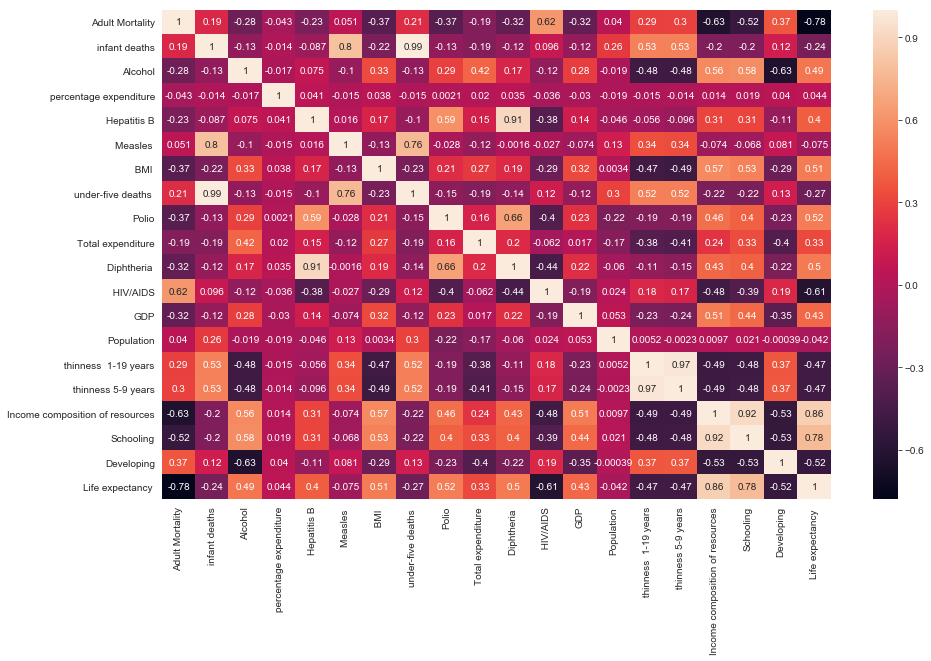

In [180]:
sns.heatmap(life_norm_log.corr(),annot = True)

In [181]:
logreg_coeffs_total = stoch_grad_desc(dataset = life_log_train,output_col = 'Developing',cols_to_ignore=['Country'],alpha = .1,epoch = 100,algo = 'log',initial_coeffs = .001)

In [182]:
logreg_coeffs_total

[3.1021292861012615,
 2.2220145121364077,
 0.26096418301195967,
 -3.950412595574187,
 0.3821347095502869,
 0.2256793673444027,
 0.16376003577312093,
 0.3754488916003908,
 0.2767633153954568,
 0.8756074813708391,
 -0.5731071257664114,
 0.2477161660732562,
 0.6536998324062663,
 -0.8099961437652633,
 0.2875429902492844,
 1.4312872293791243,
 1.472542847279053,
 -1.4951450495591374,
 -1.051940351878006,
 -0.8230799519069678]

In [183]:
life_log_test

,Country,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Developing,Life expectancy
128,Portugal,0.155280,0.000000,0.904651,0.0,0.989247,0.000089,0.786951,0.000000,0.989362,0.443564,0.989247,0.000000,0.028486,0.000515,0.022556,0.014706,0.821963,0.754839,0.0,0.813514
129,Qatar,0.138716,0.000000,0.079433,0.0,1.000000,0.000199,0.889481,0.000000,1.000000,0.067151,1.000000,0.000000,1.000000,0.042731,0.191729,0.176471,0.845258,0.548387,1.0,0.735135
130,Republic of Korea,0.130435,0.001099,0.655825,0.0,0.989247,0.000077,0.388815,0.001818,0.989362,0.300023,0.989247,0.000000,0.105744,0.042731,0.052632,0.033088,0.573610,0.517882,1.0,0.845946
131,Republic of Moldova,0.322981,0.001099,0.706984,0.0,0.881720,0.000000,0.677763,0.000909,0.882979,0.373505,0.870968,0.000000,0.105744,0.042731,0.097744,0.099265,0.573610,0.517882,1.0,0.570270
132,Romania,0.273292,0.002198,0.664228,0.0,0.032258,0.000044,0.055925,0.001818,0.893617,0.255428,0.892473,0.000000,0.134591,0.076745,0.090226,0.095588,0.750416,0.632258,0.0,0.648649
133,Russian Federation,0.457557,0.014286,0.824329,0.0,0.978495,0.009327,0.053262,0.013636,0.978723,0.321923,0.978495,0.000000,0.140178,0.005604,0.082707,0.080882,0.762063,0.651613,1.0,0.648649
134,Rwanda,0.467909,0.012088,0.417132,0.0,0.989247,0.000011,0.251664,0.013636,1.000000,0.330879,0.989247,0.032609,0.000568,0.045037,0.210526,0.205882,0.242928,0.380645,1.0,0.408108
135,Saint Lucia,0.283644,0.000000,0.852751,0.0,1.000000,0.000000,0.599201,0.000000,1.000000,0.371114,1.000000,0.000000,0.105744,0.042731,0.157895,0.154412,0.645591,0.529032,1.0,0.654054
136,Saint Vincent and the Grenadines,0.320911,0.000000,0.452276,0.0,0.989247,0.000000,0.687084,0.000000,0.978723,0.222931,0.989247,0.000000,0.105744,0.042731,0.127820,0.121324,0.620632,0.541935,1.0,0.600000
137,Samoa,0.256729,0.000000,0.199743,0.0,0.569892,0.000000,0.961385,0.000000,0.595745,0.258757,0.645161,0.000000,0.062065,0.000739,0.003759,0.000000,0.590682,0.516129,1.0,0.621622


In [184]:
logreg_total_pred = make_predictions(life_log_test,logreg_coeffs_total,'Developing',['Country'],algo = 'log')

In [185]:
logreg_total_pred

,index,Country,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Life expectancy,Developing,Prediction,Crisp,Correct?
128,128,Portugal,0.155280,0.000000,0.904651,0.0,0.989247,0.000089,0.786951,0.000000,0.989362,0.443564,0.989247,0.000000,0.028486,0.000515,0.022556,0.014706,0.821963,0.754839,0.813514,0.0,0.195873,0,True
129,129,Qatar,0.138716,0.000000,0.079433,0.0,1.000000,0.000199,0.889481,0.000000,1.000000,0.067151,1.000000,0.000000,1.000000,0.042731,0.191729,0.176471,0.845258,0.548387,0.735135,1.0,0.884107,1,True
130,130,Republic of Korea,0.130435,0.001099,0.655825,0.0,0.989247,0.000077,0.388815,0.001818,0.989362,0.300023,0.989247,0.000000,0.105744,0.042731,0.052632,0.033088,0.573610,0.517882,0.845946,1.0,0.515647,1,True
131,131,Republic of Moldova,0.322981,0.001099,0.706984,0.0,0.881720,0.000000,0.677763,0.000909,0.882979,0.373505,0.870968,0.000000,0.105744,0.042731,0.097744,0.099265,0.573610,0.517882,0.570270,1.0,0.644892,1,True
132,132,Romania,0.273292,0.002198,0.664228,0.0,0.032258,0.000044,0.055925,0.001818,0.893617,0.255428,0.892473,0.000000,0.134591,0.076745,0.090226,0.095588,0.750416,0.632258,0.648649,0.0,0.458571,0,True
133,133,Russian Federation,0.457557,0.014286,0.824329,0.0,0.978495,0.009327,0.053262,0.013636,0.978723,0.321923,0.978495,0.000000,0.140178,0.005604,0.082707,0.080882,0.762063,0.651613,0.648649,1.0,0.448660,0,False
134,134,Rwanda,0.467909,0.012088,0.417132,0.0,0.989247,0.000011,0.251664,0.013636,1.000000,0.330879,0.989247,0.032609,0.000568,0.045037,0.210526,0.205882,0.242928,0.380645,0.408108,1.0,0.964031,1,True
135,135,Saint Lucia,0.283644,0.000000,0.852751,0.0,1.000000,0.000000,0.599201,0.000000,1.000000,0.371114,1.000000,0.000000,0.105744,0.042731,0.157895,0.154412,0.645591,0.529032,0.654054,1.0,0.511214,1,True
136,136,Saint Vincent and the Grenadines,0.320911,0.000000,0.452276,0.0,0.989247,0.000000,0.687084,0.000000,0.978723,0.222931,0.989247,0.000000,0.105744,0.042731,0.127820,0.121324,0.620632,0.541935,0.600000,1.0,0.855743,1,True
137,137,Samoa,0.256729,0.000000,0.199743,0.0,0.569892,0.000000,0.961385,0.000000,0.595745,0.258757,0.645161,0.000000,0.062065,0.000739,0.003759,0.000000,0.590682,0.516129,0.621622,1.0,0.872564,1,True


In [186]:
check_accuracy(df = logreg_total_pred,algo = 'log')

0.9636363636363638

In [187]:
from sklearn.metrics import confusion_matrix,classification_report

In [188]:
print(confusion_matrix(y_true = logreg_total_pred['Developing'],y_pred = logreg_total_pred['Crisp']))

[[ 9  1]
 [ 1 44]]


In [322]:
print(classification_report(y_true = logreg_total_pred['Developing'],y_pred = logreg_total_pred['Crisp']))

             precision    recall  f1-score   support

        0.0       0.90      0.90      0.90        10
        1.0       0.98      0.98      0.98        45

avg / total       0.96      0.96      0.96        55



# Scikit-Learn Logistic Regression

In [189]:
from sklearn.linear_model import LogisticRegression

In [190]:
X = life_norm_log.drop(['Developing','Country'],axis = 1)
y = life_norm_log['Developing']

In [191]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [192]:
logreg_sklearn = LogisticRegression()

In [193]:
logreg_sklearn.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [194]:
logreg_sklearn_predictions = logreg_sklearn.predict(X_test)

In [195]:
print(confusion_matrix(y_true = y_test,y_pred=logreg_sklearn_predictions))

[[ 2  6]
 [ 0 38]]


In [196]:
print(classification_report(y_true = y_test,y_pred=logreg_sklearn_predictions))

             precision    recall  f1-score   support

        0.0       1.00      0.25      0.40         8
        1.0       0.86      1.00      0.93        38

avg / total       0.89      0.87      0.84        46

